In [10]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os


# Rock Paper Scissors Dataset Analysis
This section loads and examines the rock-paper-scissors object detection dataset. We'll load the annotation data from a CSV file and perform initial data exploration to understand the structure and quality of our dataset.

The dataset contains bounding box annotations for hand gestures representing rock, paper, and scissors poses, which will be used for training an object detection model.

In [ ]:
df_image_info = pd.read_csv('./test/_annotations.csv')
df_image_info.head()

In [ ]:
df_image_info

In [ ]:
df_image_info.describe()

## Data Quality Check

Now let's examine the dataset for potential data quality issues, including duplicate values and other inconsistencies that could affect our model training.

In [ ]:
# Check for duplicate rows
duplicate_rows = df_image_info.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

if duplicate_rows.sum() > 0:
    print("\nDuplicate rows found:")
    print(df_image_info[duplicate_rows])
else:
    print("No duplicate rows found.")

# Check for duplicate filenames
duplicate_filenames = df_image_info['filename'].duplicated()
print(f"\nNumber of duplicate filenames: {duplicate_filenames.sum()}")

if duplicate_filenames.sum() > 0:
    print("\nDuplicate filenames:")
    print(df_image_info[duplicate_filenames]['filename'].values)

# Check for any missing values
print(f"\nMissing values per column:")
print(df_image_info.isnull().sum())

# Check for invalid bounding box coordinates
invalid_boxes = df_image_info[(df_image_info['xmin'] >= df_image_info['xmax']) | 
                             (df_image_info['ymin'] >= df_image_info['ymax'])]
print(f"\nNumber of invalid bounding boxes: {len(invalid_boxes)}")

if len(invalid_boxes) > 0:
    print("Invalid bounding boxes found:")
    print(invalid_boxes)

## Data Quality Analysis Results
 
After examining the dataset for data quality issues, we found some interesting patterns:
 
 ### Duplicate Files Analysis
 The presence of duplicate filenames in our dataset is actually expected and intentional. 
These duplicates occur because some images contain multiple hands performing different gestures 
(e.g., one person showing "Rock" and another showing "Paper" in the same image). 
 
In such cases, the same image file is listed multiple times in our annotation data, each time with different bounding box coordinates corresponding to different hand regions. 
This is a common practice in object detection datasets where multiple objects of interest exist within a single image.
 
 ### Data Quality Summary
 - **Duplicate rows**: These represent legitimate multiple annotations for the same image
- **Missing values**: None found in our dataset
 - **Bounding box validity**: All bounding boxes have valid coordinates (xmin < xmax, ymin < ymax)
 
 This dataset structure is appropriate for training an object detection model that can identify and localize multiple hand gestures within a single image.


In [ ]:
# List all available styles
print(plt.style.available)

# Use a popular built-in style like 'ggplot' instead
plt.style.use('_mpl-gallery')
# Get the correct class counts
class_counts = df_image_info['class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Rock, Paper, Scissors Classes')
plt.grid(True, alpha=0.3)
plt.show()

## Sample Image Visualization

The following section demonstrates how the bounding box annotations are applied to actual images in our dataset. We'll visualize the first image with its corresponding bounding box to verify the accuracy of our annotation data.

This visualization helps us understand:
- How well the bounding boxes align with the actual hand gestures
- The quality of our annotation data
- Whether any adjustments are needed before training our object detection model

In [ ]:
current_path = os.getcwd()
image_path = f"./test/{df_image_info.loc[0, 'filename']}"
img = cv2.imread(image_path)

transform = T.Compose([
    T.ToTensor(),
])

# Load image
img = cv2.imread(image_path)
if img is not None:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
else:
    print(f"Error: Could not load image from path: {image_path}")
    print(f"Current directory: {current_path}")
    if os.path.exists(image_path):
        print("File exists but couldn't be read by cv2.imread()")
    else:
        print("File does not exist at the specified path")

# Load corresponding bounding boxes and labels
# Get bounding box coordinates from the first row
x1 = df_image_info.loc[0, 'xmin']
y1 = df_image_info.loc[0, 'ymin']
x2 = df_image_info.loc[0, 'xmax']
y2 = df_image_info.loc[0, 'ymax']

# Load image
if img is not None:
    # Load corresponding bounding boxes and labels
    boxes = [[x1, y1, x2, y2]]  # Single bounding box for the first image
    labels = [1]  # Assuming class labels: 1=Rock, 2=Paper, 3=Scissors

    # Create a target dictionary
    target = {}
    target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.tensor(labels, dtype=torch.int64)

    # Visualize the image with bounding box
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f"Class: {df_image_info.loc[0, 'class']}")
    plt.axis('off')
    plt.show()

    print(f"Target dictionary:")
    print(f"Boxes shape: {target['boxes'].shape}")
    print(f"Labels shape: {target['labels'].shape}")
    print(f"Boxes: {target['boxes']}")
    print(f"Labels: {target['labels']}")

    # Apply transform to the image
    img_tensor = transform(img)

    print(f"Original image shape: {img.shape}")
    print(f"Transformed image tensor shape: {img_tensor.shape}")
    print(f"Tensor data type: {img_tensor.dtype}")
    print(f"Tensor value range: [{img_tensor.min():.3f}, {img_tensor.max():.3f}]")

else:
    print(f"Error: Could not load image from path: {image_path}")
    print(f"Current directory: {current_path}")
    if os.path.exists(image_path):
        print("File exists but couldn't be read by cv2.imread()")
    else:
        print("File does not exist at the specified path")


In [17]:
def visualize_image_with_bbox(df, index=0, image_dir="./test/"):
    """
    Visualize an image with its bounding box annotation.
    
    Args:
        df: DataFrame containing image annotations
        index: Row index to visualize (default: 0)
        image_dir: Directory containing the images (default: "./test/")
    
    Returns:
        tuple: (img_tensor, target) if successful, (None, None) if failed
    """
    # Get image path and load image
    image_path = f"{image_dir}{df.loc[index, 'filename']}"
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Error: Could not load image from path: {image_path}")
        return None, None
    
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get bounding box coordinates
    x1 = df.loc[index, 'xmin']
    y1 = df.loc[index, 'ymin']
    x2 = df.loc[index, 'xmax']
    y2 = df.loc[index, 'ymax']
    
    # Create target dictionary
    boxes = [[x1, y1, x2, y2]]
    labels = [1]  # Placeholder label
    
    target = {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64)
    }
    
    # Visualize the image with bounding box
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, 
                                     edgecolor='red', facecolor='none', linewidth=2))
    plt.title(f"Class: {df.loc[index, 'class']}")
    plt.axis('off')
    plt.show()
    
    # Apply transform to the image
    img_tensor = transform(img)
    
    # Print information
    print(f"Target dictionary:")
    print(f"Boxes shape: {target['boxes'].shape}")
    print(f"Labels shape: {target['labels'].shape}")
    print(f"Original image shape: {img.shape}")
    print(f"Transformed image tensor shape: {img_tensor.shape}")
    
    return img_tensor, target

# Example usage
# img_tensor, target = visualize_image_with_bbox(df_image_info, index=0)


In [ ]:
# Store tensors and targets in lists
image_tensors = []
targets = []

for i in range(len(df_image_info)):
    img_tensor, target = visualize_image_with_bbox(df_image_info, index=i)
    if img_tensor is not None:
        image_tensors.append(img_tensor)
        targets.append(target)

## Model Setup

Now we'll load and configure a pre-trained Faster R-CNN model for our rock-paper-scissors object detection task. We'll use a ResNet-50 backbone with Feature Pyramid Network (FPN) and modify the classifier head to match our dataset's classes.

The model will be configured for 4 classes total:
- Background (class 0) - automatically handled by the framework
- Rock (class 1)
- Paper (class 2) 
- Scissors (class 3)

In [20]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(weights='DEFAULT')

num_classes = 4  # 3 classes (Rock, Paper, Scissors) + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Data Loader Setup

Now we'll set up the data loading pipeline for our rock-paper-scissors dataset. This involves creating data loaders that will efficiently batch and serve our training data to the model during training and validation phases.

The data loaders will handle proper batching, shuffling, and collation of our image tensors and target annotations to ensure smooth training workflow.

In [25]:
# Convert lists to tensors and create dataset
# Don't stack image_tensors since they're already individual tensors in a list
# targets = targets  # This line is redundant, removing it

# Import required modules
from torch.utils.data import Dataset, DataLoader

# Create a simple dataset from our tensors
class SimpleDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.targets[idx]

# Load dataset
dataset = SimpleDataset(image_tensors, targets)

# Split into train and validation sets
indices = torch.randperm(len(dataset)).tolist()
train_dataset = torch.utils.data.Subset(dataset, indices[:-50])
valid_dataset = torch.utils.data.Subset(dataset, indices[-50:])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, 
                         collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, 
                         collate_fn=lambda x: tuple(zip(*x)))

## Setup Training Loop

In [32]:
def validate(model, data_loader, device):
    # It's good practice to set eval mode at the beginning.
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Temporarily set the model to training mode to get the loss dictionary.
            # Because we are in a torch.no_grad() context, no gradients will be computed.
            model.train()
            loss_dict = model(images, targets)
            
            # Switch back to eval mode for the next batch or subsequent evaluations.
            model.eval()

            # The model in train() mode returns a dictionary of losses.
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    
    return total_loss / len(data_loader)

# The rest of your training loop code remains the same.
# Training parameters
num_epochs = 10
learning_rate = 0.005
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)

# Setup optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Training loop
print(f"Training on device: {device}")
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    # Now, this call will work correctly.
    val_loss = validate(model, valid_loader, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print("-" * 50)

Training on device: cpu
Epoch 1/10
Training Loss: 0.0345
Validation Loss: 0.1161
--------------------------------------------------
Epoch 2/10
Training Loss: 0.0346
Validation Loss: 0.1056
--------------------------------------------------
Epoch 3/10
Training Loss: 0.0330
Validation Loss: 0.1192
--------------------------------------------------
Epoch 4/10
Training Loss: 0.0326
Validation Loss: 0.1067
--------------------------------------------------
Epoch 5/10
Training Loss: 0.0315
Validation Loss: 0.1225
--------------------------------------------------
Epoch 6/10
Training Loss: 0.0300
Validation Loss: 0.1173
--------------------------------------------------
Epoch 7/10
Training Loss: 0.0288
Validation Loss: 0.1176
--------------------------------------------------
Epoch 8/10
Training Loss: 0.0290
Validation Loss: 0.1142
--------------------------------------------------
Epoch 9/10
Training Loss: 0.0258
Validation Loss: 0.1134
--------------------------------------------------
Epoc

## Evaluate the model

Model saved to trained_model.joblib
Model Evaluation Results:
Average IoU: 0.6235
Precision at IoU 0.5: 0.6957
Precision at IoU 0.75: 0.4638

Per-class metrics:
Paper: Average IoU = 0.9368

Visualizing sample predictions...


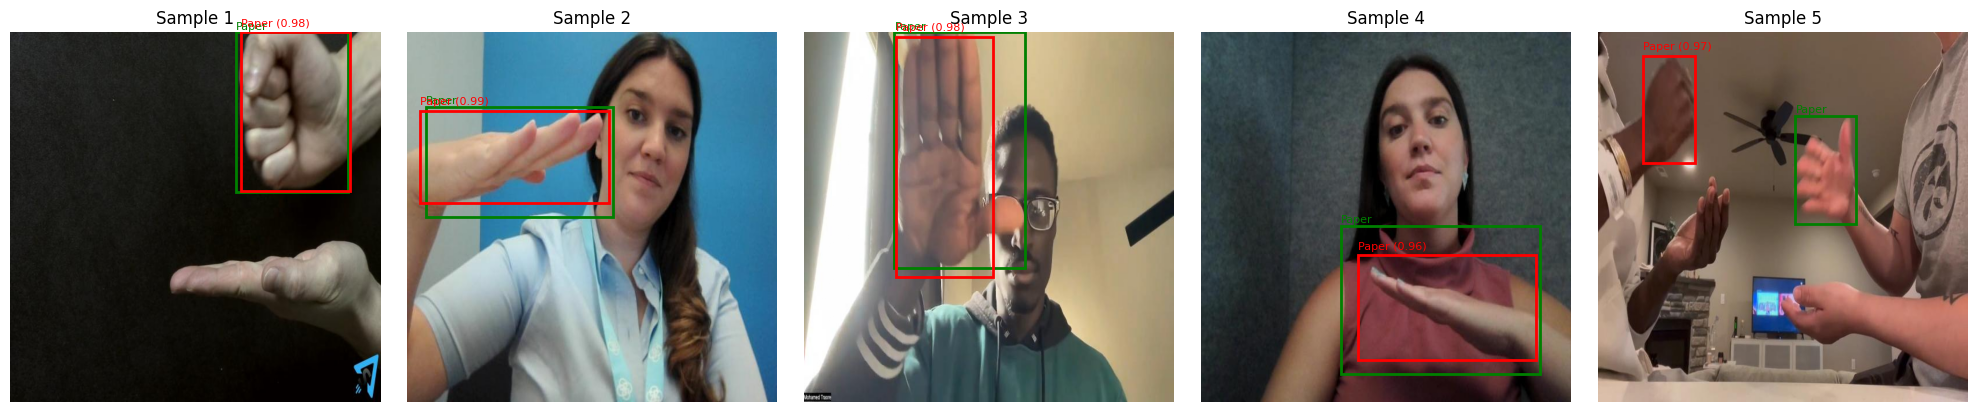

In [33]:
# Save the trained model using joblib
import joblib

# Save the model to a file
model_filename = 'trained_model.joblib'
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


# Set model to evaluation mode
model.eval()

# Lists to store predictions and ground truth
all_predictions = []
all_targets = []

# Evaluate on validation set
with torch.no_grad():
    for images, targets in valid_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Get predictions
        predictions = model(images)
        
        # Store predictions and targets
        all_predictions.extend(predictions)
        all_targets.extend(targets)

# Calculate metrics
from collections import defaultdict
import numpy as np

def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0

# Calculate mAP and IoU metrics
iou_thresholds = [0.5, 0.75]
class_names = ['Rock', 'Paper', 'Scissors']
metrics = defaultdict(list)

for pred, target in zip(all_predictions, all_targets):
    pred_boxes = pred['boxes'].cpu().numpy()
    pred_scores = pred['scores'].cpu().numpy()
    pred_labels = pred['labels'].cpu().numpy()
    
    target_boxes = target['boxes'].cpu().numpy()
    target_labels = target['labels'].cpu().numpy()
    
    # Calculate IoU for each prediction
    for i, (pred_box, pred_score, pred_label) in enumerate(zip(pred_boxes, pred_scores, pred_labels)):
        best_iou = 0
        best_match = None
        
        for j, (target_box, target_label) in enumerate(zip(target_boxes, target_labels)):
            if pred_label == target_label:
                iou = calculate_iou(pred_box, target_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match = j
        
        # Check if prediction is correct at different IoU thresholds
        for threshold in iou_thresholds:
            if best_iou >= threshold:
                metrics[f'correct_{threshold}'].append(1)
            else:
                metrics[f'correct_{threshold}'].append(0)
        
        metrics['iou_scores'].append(best_iou)

# Print evaluation results
print("Model Evaluation Results:")
print("=" * 50)

# Average IoU
avg_iou = np.mean(metrics['iou_scores'])
print(f"Average IoU: {avg_iou:.4f}")

# Precision at different IoU thresholds
for threshold in iou_thresholds:
    precision = np.mean(metrics[f'correct_{threshold}'])
    print(f"Precision at IoU {threshold}: {precision:.4f}")

# Per-class metrics
print("\nPer-class metrics:")
for class_name in class_names:
    class_ious = [iou for iou, label in zip(metrics['iou_scores'], pred_labels) 
                  if class_names[label] == class_name]
    if class_ious:
        avg_class_iou = np.mean(class_ious)
        print(f"{class_name}: Average IoU = {avg_class_iou:.4f}")

# Visualize some predictions
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_predictions(model, data_loader, num_samples=5):
    """Visualize model predictions on sample images"""
    model.eval()
    
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    if num_samples == 1:
        axes = [axes]
    
    for i, (images, targets) in enumerate(data_loader):
        if i >= num_samples:
            break
            
        image = images[0]
        target = targets[0]
        
        # Get prediction
        with torch.no_grad():
            prediction = model([image.to(device)])[0]
        
        # Convert to numpy for visualization
        img_np = image.permute(1, 2, 0).numpy()
        
        # Plot image
        ax = axes[i]
        ax.imshow(img_np)
        ax.set_title(f'Sample {i+1}')
        ax.axis('off')
        
        # Draw ground truth boxes (green)
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box.numpy()
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                   linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-5, class_names[label], color='green', fontsize=8)
        
        # Draw prediction boxes (red)
        for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
            if score > 0.5:  # Only show high confidence predictions
                x1, y1, x2, y2 = box.cpu().numpy()
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, 
                                       linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1-10, f"{class_names[label]} ({score:.2f})", 
                       color='red', fontsize=8)
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
print("\nVisualizing sample predictions...")
visualize_predictions(model, valid_loader, num_samples=5)


In [35]:
import cv2
import torch
import numpy as np
from PIL import Image
import time
from torchvision import transforms

def get_transform(train):
    """Get image transforms for training or validation"""
    transform_list = [
        transforms.Resize((800, 800)),
        transforms.ToTensor(),
    ]
    if train:
        transform_list.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(transform_list)

def webcam_detection(model, device, class_names):
    """
    Real-time object detection using webcam
    """
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return
    
    print("Webcam started. Press 'q' to quit.")
    
    while True:
        # Capture frame
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame")
            break
        
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image
        pil_image = Image.fromarray(frame_rgb)
        
        # Transform image
        transform = get_transform(train=False)
        image_tensor = transform(pil_image).unsqueeze(0)
        
        # Get prediction
        with torch.no_grad():
            prediction = model([image_tensor.to(device)])[0]
        
        # Draw predictions on frame
        for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
            if score > 0.5:  # Only show high confidence predictions
                x1, y1, x2, y2 = box.cpu().numpy().astype(int)
                
                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                
                # Add label and confidence
                label_text = f"{class_names[label]} ({score:.2f})"
                cv2.putText(frame, label_text, (x1, y1-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
        # Display frame
        cv2.imshow('Rock Paper Scissors Detection', frame)
        
        # Break loop on 'q' press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release resources
    cap.release()
    cv2.destroyAllWindows()

# Start real-time detection
print("Starting real-time webcam detection...")
webcam_detection(model, device, class_names)


Starting real-time webcam detection...
Webcam started. Press 'q' to quit.


ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([1, 3, 800, 800])